# Astro 528, Lab 7, Exercise 1
## GPU Computing I:  Getting Started & Linear Algebra

In this lab exercise, we'll verify that we have access to a GPU, learn a little about its properties and benchmark some simple operations on a GPU to see how performance compares.  While most laptops have a GPU, most will either note be setup for general purpose computing or will be so low power that the benchmarking results won't be very informative.  Therefore, students are advised to run the exercises in this lab on ICS-ACI rather than their own system (unless they're confident they have setup their own system for GPU computing properly).  

The ICS-ACI Jupyter notebook server and interactive desktop provided by the ICS-ACI portal are now using interactive notes that include a GPU, and students should be able to run all the code there.  However, the GPUs on the interactive nodes are relatively modest GPUs.  Therefore, after you've stepped through the notebook, you'll want to submit a PBS job, so you can run the calculations on one of the CyberLAMP GPU nodes.  For that step, you'll use the [command line interface](https://ics.psu.edu/computing-services/ics-aci-user-guide/#05-00-basics-aci-resources) to submit the PBS jobs, following a similar syntax as the [lab's 6 README](https://github.com/PsuAstro528/lab6-start/blob/master/README.md).  

## Setting up Julia to use the GPU
First, we need to make sure that your computer can find the [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit).  I've installed version 9.1.0 in `/gpfs/group/ebf11/default/astro528/cuda` and all students in the class should have read access to it.  In order for other packages to know where to find it, we'll set the environment variable `CUDA_HOME`.  You could do this in a dotfile (e.g., adding 
```bash 
export CUDA_HOME=/gpfs/group/ebf11/default/astro528/cuda
```
to your `~/.bashrc` *before* you start the Jupyter notebook server or interactive desktop file.  If that worked, then the next cell should return that path.  If it didn't work, then the `else` part of the next cell should set it for you.

In [1]:
if haskey(ENV,"CUDA_HOME")
    println("The CUDA_HOME environment variable has been set to: ",ENV["CUDA_HOME"])
else
    println("The CUDA_HOME environment variable has not been set.  Setting it now...")
    ENV["CUDA_HOME"] = "/gpfs/group/ebf11/default/astro528/cuda"
end

The CUDA_HOME environment variable has been set to: /gpfs/group/ebf11/default/astro528/cuda


Now, that we've told Julia were to find the CUDA toolkit, install the pacakages we'll be using, activate the current project.

In [2]:
using Pkg
Pkg.activate(".")

"/storage/work/a/axp1175/astro528/lab7-apellegrino/Project.toml"

And then install the necessary packages.  This instantiate should only need to be run once, assuming everything worked.  If you get errors, then you'll likely need to make sure CUDA_HOME is set correctly and then use `Pkg.build` to rebuild those libraries.

In [3]:
Pkg.instantiate()  # Only need to run once for the whole lab (assuming it works the first time)

  Updating registry at `~/work/julia_depot/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  99.9 %0.0 %                                 ]  15.5 % %>                     ]  46.5 %Fetching: [=====================>                   ]  50.2 %>             ]  65.6 % [=================================>       ]  81.2 % ]  96.1 % Installed CUDAapi ──── v0.6.0
 Installed GPUArrays ── v0.6.1
 Installed CUDAdrv ──── v1.0.1
 Installed CuArrays ─── v0.9.1
 Installed LLVM ─────── v1.0.0
 Installed CUDAnative ─ v1.0.1
  Building CUDAdrv ───→ `~/work/julia_depot/packages/CUDAdrv/JWljj/deps/build.log`
  Building LLVM ──────→ `~/work/julia_depot/packages/LLVM/tPWXv/deps/build.log`
  Building CUDAnative → `~/work/julia_depot/packages/CUDAnative/Mdd3w/deps/build.log`
  Building CuArrays ──→ `~/work/julia_depot/packages/CuArrays/PD3UJ/deps/build.log`


Don't worry if you get a warning about not finding the cudnn library.

## CUDAdrv:  Julia interface to the CUDA driver

For this first exercise, we'll install several packages individually to see what they do.  The [CUDAdrv.jl](https://juliagpu.gitlab.io/CUDAdrv.jl/) package is a Julia wrapper for the CUDA driver that allows programs to access an NVIDIA GPU.

In [4]:
using CUDAdrv

This provides very basic functionality, like querying what version of the CUDA Toolkit is being used,

In [5]:
CUDAdrv.version()

v"9.1.0"

initializing the GPU, querying the name of the GPU being used,

In [6]:
gpu_dev = CuDevice(0)
name(gpu_dev)

"Quadro K4000"

querying how much RAM is avaliable on the GPU,

In [7]:
gpu_ram = Int64(totalmem(gpu_dev)) 
println("GPU has ",gpu_ram/1024^3, "GB of RAM.")

GPU has 2.94744873046875GB of RAM.


and the version indicating the current GPU's ["compute capability"](https://en.wikipedia.org/wiki/CUDA#GPUs_supported).

In [8]:
capability(gpu_dev)

v"3.0.0"

In principle, the compute capability tells you the technical sepcifications of your GPU that would be needed to do fairly low-level programming.  Rather than [looking up the specs of your graphics card online](https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units), you can query [a large list of GPU attributes](https://github.com/JuliaGPU/CUDAdrv.jl/blob/master/src/devices.jl#L60).  For example, how many multi-processors does the current GPU have?

In [9]:
attribute(gpu_dev,CUDAdrv.MULTIPROCESSOR_COUNT)

4

GPUs execute many calculations at once, typically thousands or even hundreds of thousands threads are run in a single call to the GPU kernel.  The threads are grouped into "blocks" and the GPU can distribute different blocks to different multiprocessors as it sees fit.  Each blocks may be broken down into one or multiple "warps" which are run on the same multiprocessor, but not necessarily at the same time.  All computations in one warp are executed in parallel on a single multiprocessor.  Let's check the maximum number of threads per block and how many threads are in one warp on your GPU.

In [10]:
attribute(gpu_dev,CUDAdrv.MAX_THREADS_PER_BLOCK)

1024

In [11]:
warpsize(gpu_dev)

32

If you have fewer threads in a block, than the warp size, then then some of the arithmetic units in the multiprocessor won't be used effectively.  
Nevertheless, sometimes this is necessary, because there's a fixed number of registers per block.

In [12]:
attribute(gpu_dev,CUDAdrv.MAX_REGISTERS_PER_BLOCK)

65536

If one wants to get the full power of GPUs, then one is likely to do at least some low-level GPU programming in which one would need to make use of this information to choose how to divide up the work among threads and blocks efficiently.  

### GPUArrays:  A High-level Julia interface to GPU programming

For this exercise, we'll use the [GPUArrays.jl](https://github.com/JuliaGPU/GPUArrays.jl) package that provides a high-level interface that hides the above details from the programmer.  Different GPU manufacturers provide different functionality and libraries.  The GPUs at ICS-ACI are NVIDIA GPUs, and these are most efficiently programmed using [CUDA](https://en.wikipedia.org/wiki/CUDA).  On the other hand, AMD GPUs are most efficiently programmed using [OpenCL](https://en.wikipedia.org/wiki/OpenCL).  Some programmers perfer to use OpenCL, since CUDA is a proprietary language.  Julia has mid/high-level libraries for array operations for using either CUDA (i.e., [CuArrays.jl](https://github.com/JuliaGPU/CuArrays.jl)) or OpenCL (i.e., [CLArrays.jl](https://github.com/JuliaGPU/CLArrays.jl)).  It would be nice to be able to write code that can run with either type of GPU.  Indeed, the [GPUArrays.jl](https://github.com/JuliaGPU/GPUArrays.jl) package provides just that.  For many applications, [GPUArrays.jl](https://github.com/JuliaGPU/GPUArrays.jl) provides all you need to get orders of magnitude speed-up relative to a CPU.  

Since this is our first time using these packages, let's load them one at a time, just in case there are any error messages.  Since CuArrays is the lower-level package, let's first make sure that load successfully.

In [13]:
using CuArrays

┌ Info: Precompiling CuArrays [3a865a2d-5b23-5a0f-bc46-62713ec82fae]
└ @ Base loading.jl:1192


Assuming that CuArrays loaded successfuly, proceed to load the GPUArrays package.

In [14]:
using GPUArrays

First, we'll benchmark some linear algebra.  Because linear algebra is so common, there are efficient [BLAS libraries](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) avaliable for both CPUs and GPU.
Create some matrices and arrays for testing.

In [15]:
N = 1024
A_h = randn(N,N)
x_h = randn(N);

In [16]:
b_h = A_h*x_h;

To perform calculations on a GPU, we'll need to send the data from the CPU to the GPU.  The CuArrays pacakge provides a datatype `CuDeviceArray` for arrays that live on the device.  Manually specifying when to send data back and forth can be good for efficiency, but does require more care.  So instead, we use `CuArray`'s that take care of moving the data between the CPU (or "host") memory system and the GPU (or "device") memory system for us.  

We can create a 'CuArray' from an existing Array simply with the `cu(.)` function.  Then we can proceed to do arithmetic on them with the same syntax as when using standard Arrays.  (Generic programming is amazing!)

In [17]:
A_d = cu(A_h)
x_d = cu(x_h)
b_d = A_d*x_d

1024-element CuArray{Float32,1}:
  -4.176999 
  13.872379 
  -5.3182335
  53.307156 
  12.307359 
 -29.872375 
  65.09448  
  39.36636  
 -26.397562 
  -4.6430345
  67.214676 
 -23.481934 
 -10.636773 
   ⋮        
 -38.31561  
 -17.82618  
   4.512912 
 -67.2815   
 -38.11163  
  28.772501 
 -16.011162 
  29.441952 
  14.275597 
 -17.908827 
  14.635857 
  37.349983 

First, note the type of each variable.

In [18]:
typeof(A_d), typeof(x_d), typeof(b_d)

(CuArray{Float32,2}, CuArray{Float32,1}, CuArray{Float32,1})

By using a CuArray, the result calculation is also stored as a CuArray and left on the GPU.  While CuArrays let us access individual elements, if we want to look at the whole array, then it would be faster to copy all the data at once to CPU.  We can bring the full result back to the host, using `Array(.)` or `collect(.)`.

In [19]:
b_comp_h = Array(b_d)

1024-element Array{Float32,1}:
  -4.176999 
  13.872379 
  -5.3182335
  53.307156 
  12.307359 
 -29.872375 
  65.09448  
  39.36636  
 -26.397562 
  -4.6430345
  67.214676 
 -23.481934 
 -10.636773 
   ⋮        
 -38.31561  
 -17.82618  
   4.512912 
 -67.2815   
 -38.11163  
  28.772501 
 -16.011162 
  29.441952 
  14.275597 
 -17.908827 
  14.635857 
  37.349983 

Next, we'll compare the results.  What do you expect for the maximum difference in any element in `b`?
        
**The mantissa of the single-precision IEEE 754 standard is 23 bits long which is about 7 digits of information, so about 10^-7 * max(b)**

In [20]:
maximum(b_comp_h .- b_h)

2.4707735255091734e-5

How did the results compare to your expectations?  

**max(b) is of order 10^2 so this is about right, maybe a bit larger.**

One thing to keep in mind is that most "consumer grade" GPUs are designed to only perform single-precision arithmetic.  Even GPUs that do support double precission are often significantly slower at double precission arithmetic than single precission.  The difference is particularly noticable for "consumer grade" GPUs.  When we need double precission, we can specify that explicitly.  Below we will use double precision on the GPU and test its accuracy.

In [22]:
A_d64 = CuArray{Float64}(A_h)
x_d64 = CuArray{Float64}(x_h)
b_d64 = A_d64*x_d64
maximum(Array(b_d64) .- b_h)

1.9895196601282805e-13

Now, how do the results compare to your expectations?

**This is about the precision of double precision floats, but also I wonder why there is any difference at all if the calculations are the same with the same level of precision.**


## Benchmarking GPU for Linear Algebra
Now, we'll do some benchmarking of the CPU vs GPU, so let's load the usual BenchmarkTools package.

In [23]:
using BenchmarkTools, Statistics

┌ Info: Recompiling stale cache file /storage/home/axp1175/work/julia_depot/compiled/v1.0/BenchmarkTools/ZXPQo.ji for BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1190


Note that we'll be able to use the exact same macros to benchmark code running on either the CPU or the GPU.  To keep things reasonably fast, we'll specify that we only want Julia to benchmark each calculation a few times.  
Calls to the GPU run asynchronously.  So if we want to benchmark how long is required to the calculation to complete, we need to tell Julia to wait until the calculation has been synchronized.  We can do that either with the `@sync` macro in CuArrays or with the `synchronize(.)` function in GPUArrays to make our code more general.  `@sync` makes everyone wait until everything is complete.  `synchronize(x)` only waits until the array `x` is synchronized.

In [24]:
@benchmark b_d = $A_d*$x_d samples=5

BenchmarkTools.Trial: 
  memory estimate:  592 bytes
  allocs estimate:  22
  --------------
  minimum time:     10.724 μs (0.00% GC)
  median time:      14.457 μs (0.00% GC)
  mean time:        25.627 μs (0.00% GC)
  maximum time:     75.353 μs (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

How long does it take to launch the GPU kernel and exit?

**~15 μs**

In [25]:
@benchmark CuArrays.@sync( b_d = $A_d*$x_d) samples=5

BenchmarkTools.Trial: 
  memory estimate:  704 bytes
  allocs estimate:  26
  --------------
  minimum time:     103.621 μs (0.00% GC)
  median time:      117.066 μs (0.00% GC)
  mean time:        188.971 μs (0.00% GC)
  maximum time:     351.725 μs (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

How long did it take to complete the calculation and store to to an array on the GPU?  How does this compare to the cost of launching the kernel?  What are the implications for the ammount of work you'd want per GPU call in order to make efficient use of the GPU?

**~115 μs, several times the cost of lauching the kernel itself. Therefore the work per GPU call would have to be much larger to make it efficient.**

In [26]:
@benchmark ( b_d .= $A_d*$x_d;  GPUArrays.synchronize(b_d); ) samples=5

┌ Info: Building the CUDAnative run-time library for your sm_30 device, this might take a while...
└ @ CUDAnative /storage/home/axp1175/work/julia_depot/packages/CUDAnative/Mdd3w/src/compiler/rtlib.jl:156


BenchmarkTools.Trial: 
  memory estimate:  2.16 KiB
  allocs estimate:  62
  --------------
  minimum time:     77.809 μs (0.00% GC)
  median time:      82.262 μs (0.00% GC)
  mean time:        92.888 μs (0.00% GC)
  maximum time:     142.107 μs (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

We can compare that to double precission

In [27]:
@benchmark ( b_d64 .= $A_d64*$x_d64;  GPUArrays.synchronize(b_d64); ) samples=5

BenchmarkTools.Trial: 
  memory estimate:  2.16 KiB
  allocs estimate:  62
  --------------
  minimum time:     126.050 μs (0.00% GC)
  median time:      126.492 μs (0.00% GC)
  mean time:        147.182 μs (0.00% GC)
  maximum time:     227.539 μs (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

Since we'll want to perform benchmarks for several problem sizes, I've provided a function `run_benchmarks` to make things a little easier.

In [28]:
""" run_benchmarks(N; opts)
Benchmark matrix-vector multiplication and optionally linear solve.
Optional arguments:
- num_samples:  How many times to perform each calculation being benchmarked
- calc_solve: Whether to benchmark linear solve (false)
- run_cpu:  Whether to perform benchmarks on cpu (true)
- run_gpu:  Whether to perform benchmarks on gpu (false)
- verbose:  Whether to print status updates.
Output: A dictionary with results of each benchmark performed and 
        optionally the difference in final CPU and GPU calculations (if both are run).  
"""
function run_benchmarks(N::Integer; num_samples=3, run_cpu=true, run_gpu=false,
                            gpu_type = Float32, mat_vec=true, mat_mat=false, compare=false, verbose=false )
   verbose && println("Benchmarking with problem size = ",N)
   A_h = randn(N,N)
   x_h = randn(N)
   output = Dict()
   if run_gpu
      A_d = CuArray{gpu_type}(A_h)
      x_d = CuArray{gpu_type}(x_h)
   end
   if mat_vec
      if run_cpu
         verbose && println("Benchmarking matrix-vector multiply on CPU")
         # The `$` signs below specify that we want benchmark to use the local variables, rather than global variables with same name
         output["cpu_mat_vec_mul"] = @benchmark b_h = $A_h*$x_h samples=num_samples
      end
      if run_gpu
         verbose && println("Benchmarking matrix-vector multiply on GPU")
         #output["gpu_mat_vec_mul"] = @benchmark CuArrays.@sync( b_d = $A_d*$x_d) samples=num_samples
         output["gpu_mat_vec_mul"] = @benchmark ( b_d = $A_d*$x_d; GPUArrays.synchronize(b_d) ) samples=num_samples
      end
      if run_cpu && run_gpu && compare
        b_h = A_h*x_h
        b_d = A_d*x_d
        output["diff_mat_vec_mul"] = convert(typeof(b_h),Array(b_d)).-b_h
      end
   end
   if mat_mat
      if run_cpu
         verbose && println("Benchmarking matrix-matrix multiply on CPU")
         # The `$` signs below specify that we want benchmark to use the local variables, rather than global variables with same name
         output["cpu_mat_mat_mul"] = @benchmark Asq_h = $A_h*$A_h' samples=num_samples
      end
      if run_gpu
         verbose && println("Benchmarking matrix-matrix multiply on GPU")
         output["gpu_mat_mat_mul"] = @benchmark ( Asq_d = $A_d*$A_d'; GPUArrays.synchronize(Asq_d) ) samples=num_samples
      end
      if run_cpu && run_gpu && compare
        Asq_h = A_h*A_h'
        Asq_d = A_d*A_d'
        output["diff_mat_mat_mul"] = convert(typeof(Asq_h),Array(Asq_d)).-Asq_h
      end
   end
   return output
end

run_benchmarks

First, do a quick test to see how it works.

In [29]:
have_gpu = @isdefined GPUArrays
benchmark_result = run_benchmarks(128,verbose=true,mat_vec=true,run_gpu=have_gpu,compare=true)

Benchmarking with problem size = 128
Benchmarking matrix-vector multiply on CPU
Benchmarking matrix-vector multiply on GPU


Dict{Any,Any} with 3 entries:
  "diff_mat_vec_mul" => [4.7066e-7, 7.60654e-7, 2.18365e-7, -1.05561e-7, 5.6252…
  "gpu_mat_vec_mul"  => Trial(28.267 μs)
  "cpu_mat_vec_mul"  => Trial(3.623 μs)

We'll extract the median run time for the multiplication using the CPU with expressions like

In [30]:
median(benchmark_result["cpu_mat_vec_mul"].times)

3708.875

And compare this to the performance using double precission.

In [31]:
have_gpu = @isdefined GPUArrays
benchmark_result = run_benchmarks(128,verbose=true,gpu_type=Float64,mat_vec=true,run_gpu=have_gpu,compare=true)
median(benchmark_result["cpu_mat_vec_mul"].times)

Benchmarking with problem size = 128
Benchmarking matrix-vector multiply on CPU
Benchmarking matrix-vector multiply on GPU


3674.75

Now let's perform run some benchmarks and plot the results.  After you've made your first plot, you may want to increase the range of problem sizes slightly to extend your plot.

In [32]:
using Plots
#pyplot()  # in case gr() gives you trouble

┌ Info: Recompiling stale cache file /storage/home/axp1175/work/julia_depot/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


In [33]:
problem_sizes = [2^i for i in 2:12]
benchmark_results32 = map( s->run_benchmarks(s,mat_mat=true,run_gpu=have_gpu,gpu_type=Float32), problem_sizes )

11-element Array{Dict{Any,Any},1}:
 Dict("cpu_mat_mat_mul"=>Trial(359.779 ns),"gpu_mat_mat_mul"=>Trial(27.821 μs),"gpu_mat_vec_mul"=>Trial(24.904 μs),"cpu_mat_vec_mul"=>Trial(93.244 ns)) 
 Dict("cpu_mat_mat_mul"=>Trial(803.026 ns),"gpu_mat_mat_mul"=>Trial(27.670 μs),"gpu_mat_vec_mul"=>Trial(26.736 μs),"cpu_mat_vec_mul"=>Trial(103.627 ns))
 Dict("cpu_mat_mat_mul"=>Trial(2.380 μs),"gpu_mat_mat_mul"=>Trial(26.958 μs),"gpu_mat_vec_mul"=>Trial(26.322 μs),"cpu_mat_vec_mul"=>Trial(206.172 ns))  
 Dict("cpu_mat_mat_mul"=>Trial(7.183 μs),"gpu_mat_mat_mul"=>Trial(28.257 μs),"gpu_mat_vec_mul"=>Trial(29.276 μs),"cpu_mat_vec_mul"=>Trial(309.011 ns))  
 Dict("cpu_mat_mat_mul"=>Trial(30.021 μs),"gpu_mat_mat_mul"=>Trial(34.604 μs),"gpu_mat_vec_mul"=>Trial(26.685 μs),"cpu_mat_vec_mul"=>Trial(1.273 μs))   
 Dict("cpu_mat_mat_mul"=>Trial(155.759 μs),"gpu_mat_mat_mul"=>Trial(66.124 μs),"gpu_mat_vec_mul"=>Trial(28.283 μs),"cpu_mat_vec_mul"=>Trial(3.478 μs))  
 Dict("cpu_mat_mat_mul"=>Trial(974.506 μs),"gpu

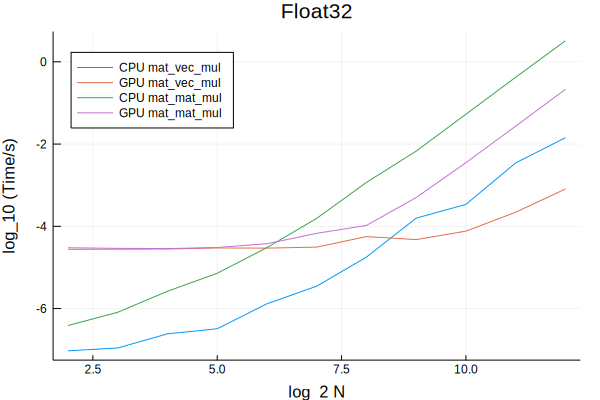

In [34]:
cpu_times = map(i->median(benchmark_results32[i]["cpu_mat_vec_mul"].times),1:length(problem_sizes))
plt = plot(log2.(problem_sizes),log10.(cpu_times*1e-9), label="CPU mat_vec_mul",xaxis="log_2 N", yaxis="log_10 (Time/s)", title="Float32", legend=:topleft)
if haskey(benchmark_results32[1],"gpu_mat_vec_mul")
    gpu_times = map(i->median(benchmark_results32[i]["gpu_mat_vec_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(gpu_times*1e-9), label="GPU mat_vec_mul")
end
if haskey(benchmark_results32[1],"cpu_mat_mat_mul")
    cpu_times = map(i->median(benchmark_results32[i]["cpu_mat_mat_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(cpu_times*1e-9), label="CPU mat_mat_mul")
end
if haskey(benchmark_results32[1],"gpu_mat_mat_mul")
    gpu_times = map(i->median(benchmark_results32[i]["gpu_mat_mat_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(gpu_times*1e-9), label="GPU mat_mat_mul")
end
display(plt)

In [35]:
problem_sizes = [2^i for i in 2:9]
benchmark_results64 = map( s->run_benchmarks(s,mat_mat=false,run_gpu=have_gpu,gpu_type=Float64), problem_sizes )

8-element Array{Dict{Any,Any},1}:
 Dict("gpu_mat_vec_mul"=>Trial(25.441 μs),"cpu_mat_vec_mul"=>Trial(119.645 ns))
 Dict("gpu_mat_vec_mul"=>Trial(26.006 μs),"cpu_mat_vec_mul"=>Trial(109.604 ns))
 Dict("gpu_mat_vec_mul"=>Trial(26.904 μs),"cpu_mat_vec_mul"=>Trial(149.027 ns))
 Dict("gpu_mat_vec_mul"=>Trial(27.316 μs),"cpu_mat_vec_mul"=>Trial(301.410 ns))
 Dict("gpu_mat_vec_mul"=>Trial(33.408 μs),"cpu_mat_vec_mul"=>Trial(983.414 ns))
 Dict("gpu_mat_vec_mul"=>Trial(29.057 μs),"cpu_mat_vec_mul"=>Trial(3.630 μs))  
 Dict("gpu_mat_vec_mul"=>Trial(51.784 μs),"cpu_mat_vec_mul"=>Trial(17.811 μs)) 
 Dict("gpu_mat_vec_mul"=>Trial(54.377 μs),"cpu_mat_vec_mul"=>Trial(68.183 μs)) 

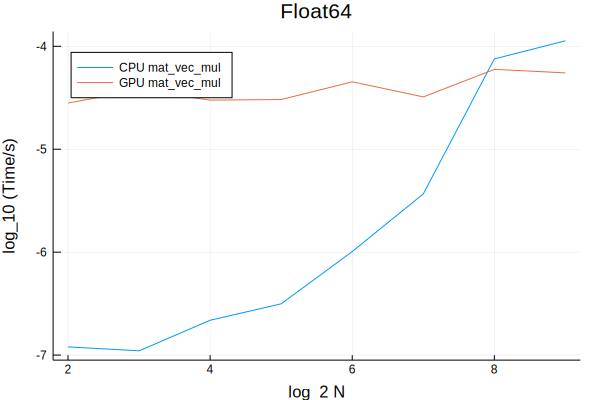

In [36]:
cpu_times = map(i->median(benchmark_results64[i]["cpu_mat_vec_mul"].times),1:length(problem_sizes))
plt = plot(log2.(problem_sizes),log10.(cpu_times*1e-9), label="CPU mat_vec_mul",xaxis="log_2 N", yaxis="log_10 (Time/s)", title="Float64", legend=:topleft)
if haskey(benchmark_results64[1],"gpu_mat_vec_mul")
    gpu_times = map(i->median(benchmark_results64[i]["gpu_mat_vec_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(gpu_times*1e-9), label="GPU mat_vec_mul")
end
if haskey(benchmark_results64[1],"cpu_mat_mat_mul")
    cpu_times = map(i->median(benchmark_results64[i]["cpu_mat_mat_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(cpu_times*1e-9), label="CPU mat_mat_mul")
end
if haskey(benchmark_results64[1],"gpu_mat_mat_mul")
    gpu_times = map(i->median(benchmark_results64[i]["gpu_mat_mat_mul"].times),1:length(problem_sizes))
    plt = plot!(log2.(problem_sizes),log10.(gpu_times*1e-9), label="GPU mat_mat_mul")
end
display(plt)

## Implications for your class project
Does your project involve linear algebra on large matrices/vectors?  Does it use thousands of linear algebra calculations with smaller matrices/vectors?
If yes to either, then discuss the implications of the results from this exercise for the suitability of using GPUs to accelerate the linear algebra in your class project.  What precission would you use?

**The neural network part of the program is certainly linear algebra heavy, but essentially the GPU parallelization has already been done in the Flux package. The rest of the program probably could not take advantage of GPUs for a significant speedup.**